### 1.Kütüphanelerin Import Edilmesi

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import random
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"You are using {device}")

You are using cuda


### 2.Verinin Çekilmesi ve Dönşüm İşleminin Yapılması

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [14]:
train_data = torchvision.datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = transform
)

test_data = torchvision.datasets.CIFAR10(
    root = "data",
    train = False,
    download = True,
    transform = transform
)

Files already downloaded and verified
Files already downloaded and verified


### 3.Verinin İncelenmesi

In [15]:
train_data, test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

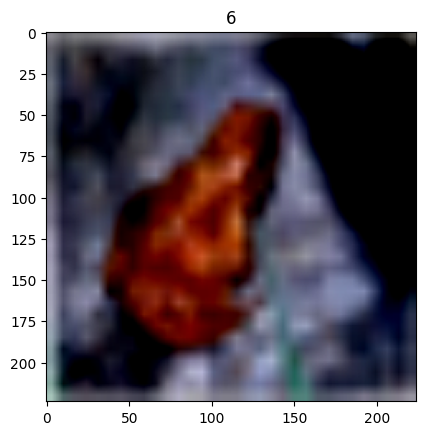

In [17]:
rand_num = random.randint(0, len(train_data))
train_img, train_label = train_data[rand_num]
plt.title(train_label)
plt.imshow(train_img.permute(1,2,0))

### 4.DataLoaderların Oluşturulması

In [18]:
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = True)

### 5.Modelin Oluşturulması
Modelde normalde alpha beta parametreleri kullanılarak model derinliği ayarlanabilir hale getirilmiştir. RMSProp algoritması ile optimize edilmiştir.

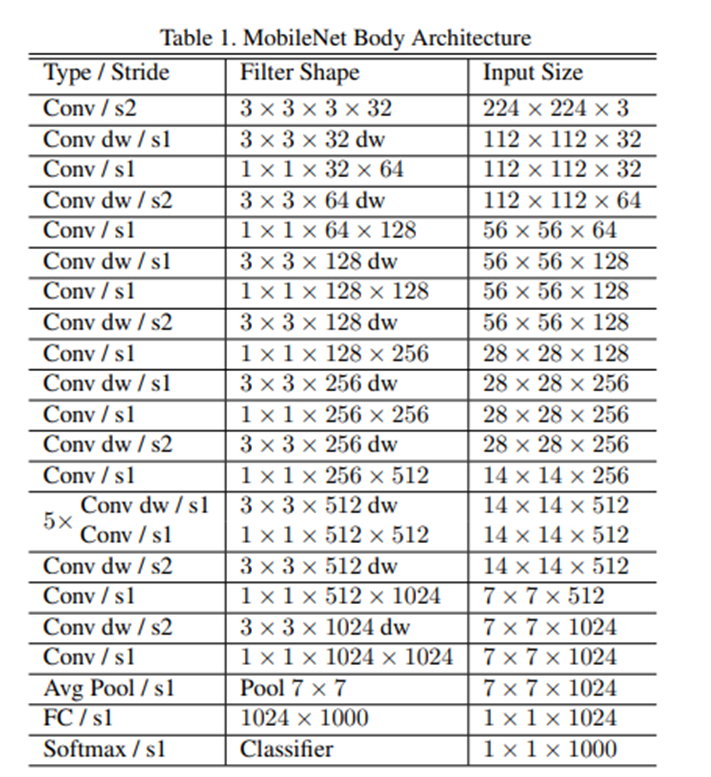

In [ ]:
class DepthwiseSeperableConv(nn.Module):
  def __init__(self, in_channels, out_channels, stride) -> None:
    super(DepthwiseSeperableConv, self).__init__()
    self.depthwise = nn.Conv2d(in_channels=in_channels, out_channels = in_channels,
                          stride = stride, kernel_size = 3, padding =1, groups=in_channels) #groups parametresi normal konvolüsyondan ayrılarak kernelin çıkış filtresine de uygulanmasını engeller ve parametre sayısının azaltılmasını sağlar.
    self.pointwise = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, stride = 1,
                               kernel_size = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
  def forward(self, x) -> torch.Tensor:
    x = self.depthwise(x)
    x = self.pointwise(x)
    x = self.bn(x)
    x = self.relu(x)
    return x

In [ ]:
class MobileNetv1(nn.Module):
  def __init__(self) -> None:
    super(MobileNetv1, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, stride = 2, kernel_size = 3, padding = 1)
    self.layers = nn.Sequential(
                  DepthwiseSeperableConv(in_channels = 32, out_channels = 64, stride = 1),
                  DepthwiseSeperableConv(in_channels = 64, out_channels = 128, stride = 2),
                  DepthwiseSeperableConv(in_channels = 128, out_channels = 128, stride = 1),
                  DepthwiseSeperableConv(in_channels=128, out_channels=256, stride=2),
                  DepthwiseSeperableConv(in_channels=256, out_channels=256, stride=1),
                  DepthwiseSeperableConv(in_channels=256, out_channels=512, stride=2),
                  DepthwiseSeperableConv(in_channels=512, out_channels=512, stride=1),
                  DepthwiseSeperableConv(in_channels=512, out_channels=512, stride=1),
                  DepthwiseSeperableConv(in_channels=512, out_channels=512, stride=1),
                  DepthwiseSeperableConv(in_channels=512, out_channels=512, stride=1),
                  DepthwiseSeperableConv(in_channels=512, out_channels=512, stride=1),
                  DepthwiseSeperableConv(in_channels=512, out_channels=1024, stride=2),
                  DepthwiseSeperableConv(in_channels=1024, out_channels=1024, stride=1))
    self.avgpool = nn.AvgPool2d(kernel_size = 7)
    self.fc = nn.Linear(in_features = 1024, out_features = 10) #Class sayısı kadar
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x) -> torch.Tensor:
    x = self.conv1(x)
    x = self.layers(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    x = self.softmax(x)
    return x

In [27]:
model = MobileNetv1().to(device)
model

MobileNetv1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layers): Sequential(
    (0): DepthwiseSeperableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): DepthwiseSeperableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): DepthwiseSeperableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum

In [28]:
rand_tens = torch.rand(1, 3, 224, 224).to(device)
model(rand_tens)

tensor([[0.0967, 0.1380, 0.0993, 0.0929, 0.1030, 0.0905, 0.0829, 0.1088, 0.1002,
         0.0878]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [30]:
optim = torch.optim.RMSprop(params = model.parameters(), lr = 10e-3)
loss = nn.CrossEntropyLoss()

In [31]:
def train(model, optimizer, loss_fn, train_loader, epochs = 10):
  model.train()
  for epoch in range(epochs):
    train_loss = []
    avg_loss = 0.0
    for batch, (X, y) in train_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_loss += loss.item()
    avg_loss = avg_loss/len(train_loader)
    train_loss.append(avg_loss)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss}")
  return train_loss

In [ ]:
def test(model, loss_fn, test_loader):
  model.eval()
  test_loss = []
  avg_loss = 0.0
  with torch.no_grad():
    for batch, (X, y) in test_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      avg_loss += loss.item()
    avg_loss = avg_loss/len(test_loader)
    test_loss.append(avg_loss)
    print(f"Loss: {avg_loss}")
  return test_loss

In [ ]:
train_losses = train(model, optim, loss, train_dataloader, epochs = 10)
train_losses

In [ ]:
test_losses = test(model, optim, loss, test_dataloader)
test_losses